In [4]:
%cd ..

c:\Users\HP\OneDrive - University of Moratuwa\Desktop\E-Vision-Projects\Shelf_Product_Count_Generation


In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [31]:
def showplt(image, title=None, pltnative=False):
    if pltnative: 
        plt.imshow(image)
    else: 
        plt.imshow(image[...,::-1])
    plt.title(title)
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()
    
def warpImages(img1, img2, H):
    rows1, cols1 = img1.shape[:2]
    rows2, cols2 = img2.shape[:2]
    
    list_of_points_1 = np.float32([
        [0,0], 
        [0,rows1],
        [cols1,rows1], 
        [cols1,0]
    ])
    list_of_points_1 = list_of_points_1.reshape(-1,1,2)

    temp_points = np.float32([
        [0,0], 
        [0,rows2], 
        [cols2,rows2],
        [cols2,0]
    ])
    temp_points = temp_points.reshape(-1,1,2)
    
    list_of_points_2 = cv2.perspectiveTransform(temp_points, H)
    
    list_of_points = np.concatenate((list_of_points_1, list_of_points_2), axis=0)
    
    ##Define boundaries:
    [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)
    
    translation_dist = [-x_min,-y_min]
    
    H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0,0,1]])
    
    output_img = cv2.warpPerspective(img2, 
                                     H_translation.dot(H), 
                                     (x_max - x_min, y_max - y_min))
    ## Paste the image:
    output_img[translation_dist[1]:rows1+translation_dist[1], 
               translation_dist[0]:cols1+translation_dist[0]] = img1
    
    return output_img
#
def warp(img1, img2, min_match_count = 10):
    sift = cv2.SIFT_create()
    
    # Extract the keypoints and descriptors
    keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2, None)
    
    # Initialize parameters for Flann based matcher
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    
    # Initialize the Flann based matcher object
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    
    # Compute the matches
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)
    
    # Store all the good matches as per Lowe's ratio test
    good_matches = []
    for m1,m2 in matches:
        if m1.distance < 0.7*m2.distance:
            good_matches.append(m1)
            
    if len(good_matches) > min_match_count:
        src_pts = np.float32([ keypoints1[good_match.queryIdx].pt
                              for good_match in good_matches ]).reshape(-1,1,2)
        
        dst_pts = np.float32([ keypoints2[good_match.trainIdx].pt 
                              for good_match in good_matches ]).reshape(-1,1,2)
        
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        result = warpImages(img2, img1, M)
        return result
        #cv2.imshow('Stitched output', result)
        #cv2.waitKey()
    else:
        print ("We don't have enough number of matches between the two images.")
        print ("Found only " + str(len(good_matches)) + " matches.")
        print ("We need at least " + str(min_match_count) + " matches.")
        
def save_image(directory, file_name, image):
    if not os.path.exists(directory):
            os.makedirs(directory)
    cv2.imwrite(directory+'/'+file_name, image)

In [32]:
#Read the images from your directory
dim=(1024,768)
left=cv2.imread('data/test_images/IMG_2218.jpeg',cv2.IMREAD_COLOR)
left=cv2.resize(left,dim,interpolation = cv2.INTER_AREA)   #ReSize to (1024,768)
right=cv2.imread('data/test_images/IMG_2219.jpeg',cv2.IMREAD_COLOR)
right=cv2.resize(right,dim,interpolation = cv2.INTER_AREA) #ReSize to (1024,768)

images=[]
images.append(left)
images.append(right)

In [33]:
# img1 = cv2.imread('data/test_images/IMG_2218.jpeg')
# img2 = cv2.imread('data/test_images/IMG_2219.jpeg')

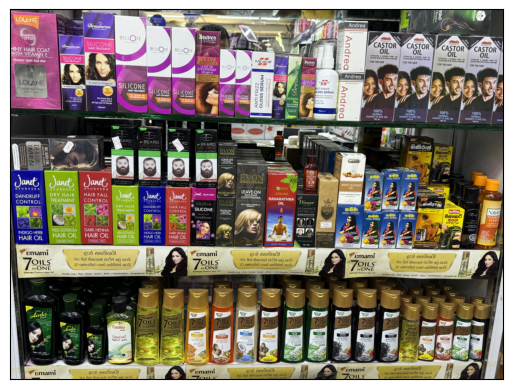

In [34]:
showplt(left)

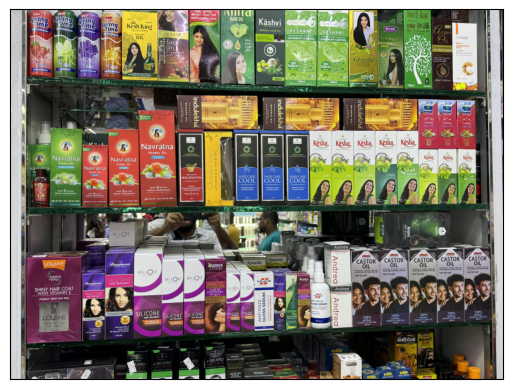

In [35]:
showplt(right)

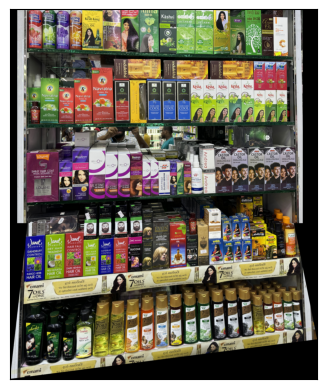

In [36]:
pano = warp(left, right)
save_image('data/output','shelf_stitched.jpg',pano)
showplt(pano)

Loading image 1: data/test_images/IMG_2217.jpeg

Stitching image 2: data/test_images/IMG_2218.jpeg
✓ Successfully stitched image 2

Stitching image 3: data/test_images/IMG_2219.jpeg
✓ Successfully stitched image 3

✓ All 3 images stitched successfully!


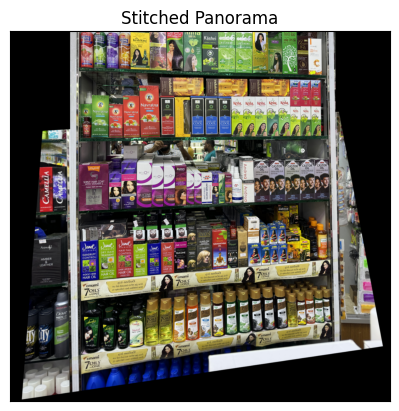

In [37]:
def stitch_multiple_images(image_paths, dim=(1024, 768), min_match_count=10):
    """
    Stitch multiple images sequentially from left to right.
    
    Args:
        image_paths: List of image file paths in order (left to right)
        dim: Resize dimension (width, height)
        min_match_count: Minimum matches required for stitching
        
    Returns:
        Stitched panoramic image
    """
    if len(image_paths) < 2:
        print("Need at least 2 images to stitch")
        return None
    
    # Load and resize first image
    print(f"Loading image 1: {image_paths[0]}")
    result = cv2.imread(image_paths[0], cv2.IMREAD_COLOR)
    
    if result is None:
        print(f"Error: Could not read image: {image_paths[0]}")
        return None
    
    result = cv2.resize(result, dim, interpolation=cv2.INTER_AREA)
    
    # Sequentially stitch each image
    for i in range(1, len(image_paths)):
        print(f"\nStitching image {i+1}: {image_paths[i]}")
        
        # Load next image
        next_img = cv2.imread(image_paths[i], cv2.IMREAD_COLOR)
        
        if next_img is None:
            print(f"Error: Could not read image: {image_paths[i]}")
            return None
        
        next_img = cv2.resize(next_img, dim, interpolation=cv2.INTER_AREA)
        
        # Stitch with accumulated result
        result = warp(result, next_img, min_match_count)
        
        if result is None:
            print(f"Failed to stitch image {i+1}")
            return None
        
        print(f"✓ Successfully stitched image {i+1}")
    
    print(f"\n✓ All {len(image_paths)} images stitched successfully!")
    return result

# Usage with multiple images - FIX: Added missing comma
image_paths = [
    'data/test_images/IMG_2217.jpeg',  # <- Missing comma was here
    'data/test_images/IMG_2218.jpeg',
    'data/test_images/IMG_2219.jpeg'
]

panorama = stitch_multiple_images(image_paths, dim=(1024, 768))

if panorama is not None:
    save_image('data/output', 'shelf_panorama.jpg', panorama)
    showplt(panorama, title='Stitched Panorama')
else:
    print("Stitching failed!")

In [38]:
# Source - https://stackoverflow.com/a
# Posted by Froyo, modified by community. See post 'Timeline' for change history
# Retrieved 2025-12-11, License - CC BY-SA 3.0
import matplotlib.pyplot as plt
import cv2
img = cv2.imread("data/test_images/IMG_2237.jpeg")
img.shape

(5712, 4284, 3)

In [39]:
cropped_image_1 = img[0:2800, 0:2500]
cropped_image_2 = img[2500:, 0:2600]
cropped_image_3 = img[2400:, 2300:]
cropped_image_4 = img[0:3400:, 2000:]

In [40]:
cv2.imwrite("data/test/cropped_image_1.jpg", cropped_image_1)
cv2.imwrite("data/test/cropped_image_2.jpg", cropped_image_2)
cv2.imwrite("data/test/cropped_image_3.jpg", cropped_image_3)
cv2.imwrite("data/test/cropped_image_4.jpg", cropped_image_4)

True

Loading image 1: data/test/cropped_image_1.jpg

Stitching image 2: data/test/cropped_image_2.jpg
✓ Successfully stitched image 2

Stitching image 3: data/test/cropped_image_3.jpg
✓ Successfully stitched image 3

Stitching image 4: data/test/cropped_image_4.jpg
✓ Successfully stitched image 4

✓ All 4 images stitched successfully!


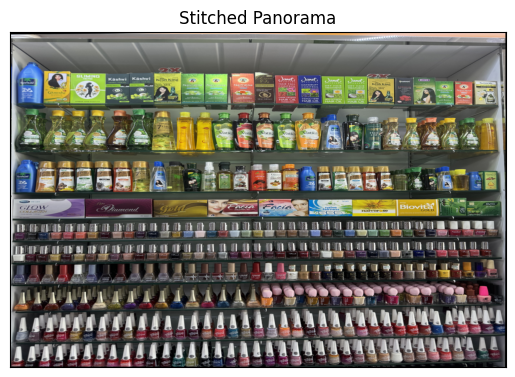

In [42]:
# Usage with multiple images - FIX: Added missing comma
image_paths = [
    "data/test/cropped_image_1.jpg",  # <- Missing comma was here
    "data/test/cropped_image_2.jpg",
    "data/test/cropped_image_3.jpg",
    "data/test/cropped_image_4.jpg"
]

panorama = stitch_multiple_images(image_paths, dim=(1024, 768))

if panorama is not None:
    save_image('data/output', 'shelf_panorama.jpg', panorama)
    showplt(panorama, title='Stitched Panorama')
else:
    print("Stitching failed!")